<a href="https://colab.research.google.com/github/markaljm/ABMSBusTracking/blob/main/Worked_code_FD_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install geopandas rasterio numpy scikit-image matplotlib

Saving Trinidad_Road.zip to Trinidad_Road (1).zip
Archive:  Trinidad_Road.zip
  inflating: Trinidad_Road.sbn       
  inflating: Trinidad_Road.sbx       
  inflating: Trinidad_Road.cpg       
  inflating: Trinidad_Road.dbf       
  inflating: Trinidad_Road.shp       
  inflating: Trinidad_Road.shx       
  inflating: Trinidad_Road.prj       
Skipping epsilon 54.37 m (avoids 3344367 pixels)
Skipping epsilon 27.18 m (avoids 13377469 pixels)
Skipping epsilon 13.59 m (avoids 53509877 pixels)
Scale: 111341.97m, Box count: 1
Scale: 55670.98m, Box count: 4
Scale: 27835.49m, Box count: 14
Scale: 13917.75m, Box count: 43
Scale: 6958.87m, Box count: 131
Scale: 3479.44m, Box count: 428
Scale: 1739.72m, Box count: 1399
Scale: 869.86m, Box count: 4569
Scale: 434.93m, Box count: 13885
Scale: 217.46m, Box count: 38417
Scale: 108.73m, Box count: 97988

Fractal Dimension: 1.660


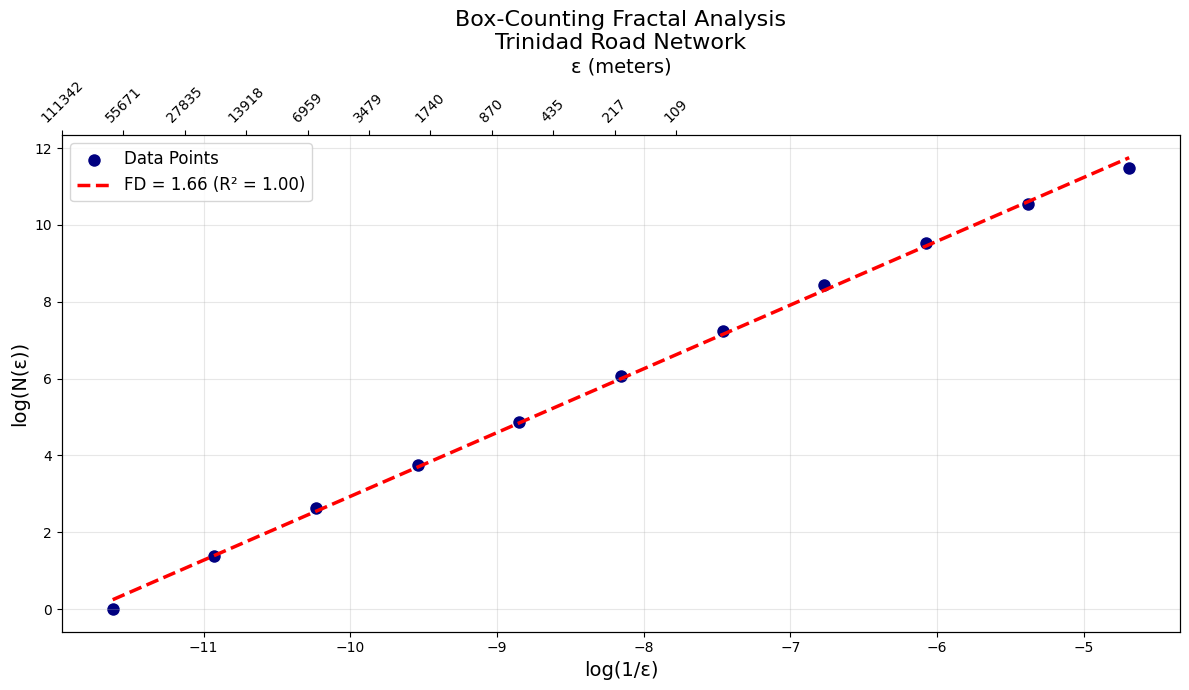

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import os

# Upload the ZIP file containing shapefiles
uploaded = files.upload()

# Unzip the uploaded file
!unzip Trinidad_Road.zip

# Load the road data
roads = gpd.read_file('Trinidad_Road.shp')

# Project to UTM Zone 20N (EPSG:32620) if needed
if roads.crs.is_geographic:
    roads = roads.to_crs(epsg=32620)

# Get the bounding box
xmin, ymin, xmax, ymax = roads.total_bounds

# Define epsilon range (box sizes)
max_epsilon = max(xmax - xmin, ymax - ymin)
min_epsilon = 10  # Minimum box size
epsilons = []
current_epsilon = max_epsilon
while current_epsilon >= min_epsilon:
    epsilons.append(current_epsilon)
    current_epsilon /= 2

# Filter epsilons to avoid memory issues
max_pixels = 1e6
filtered_epsilons = []
for e in epsilons:
    width = (xmax - xmin) / e
    height = (ymax - ymin) / e
    if width * height > max_pixels:
        print(f"Skipping epsilon {e:.2f} m (avoids {width*height:.0f} pixels)")
        continue
    filtered_epsilons.append(e)
epsilons = filtered_epsilons

# Box-counting implementation
counts = []
for epsilon in epsilons:
    width = int(np.ceil((xmax - xmin) / epsilon))
    height = int(np.ceil((ymax - ymin) / epsilon))

    transform = from_origin(xmin, ymax, epsilon, epsilon)

    shapes = [(geom, 1) for geom in roads.geometry]
    burned = features.rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.uint8,
        all_touched=True
    )

    counts.append(np.count_nonzero(burned))
    print(f"Scale: {epsilon:.2f}m, Box count: {counts[-1]}")

# Calculate fractal dimension
x = np.log([1/e for e in epsilons]).reshape(-1, 1)
y = np.log(counts)
model = LinearRegression().fit(x, y)
fd = model.coef_[0]

print(f"\nFractal Dimension: {fd:.3f}")

# Plotting with enhanced visualization
plt.figure(figsize=(12, 7))
plt.scatter(x, y, s=100, c='navy', edgecolor='white', label='Data Points')
plt.plot(x, model.predict(x), 'r--', lw=2.5,
         label=f'FD = {fd:.2f} (R² = {model.score(x,y):.2f})')

plt.xlabel('log(1/ε)', fontsize=14)
plt.ylabel('log(N(ε))', fontsize=14)
plt.title('Box-Counting Fractal Analysis\nTrinidad Road Network', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add secondary axis with actual scales
ax2 = plt.gca().twiny()
ax2.set_xlabel('ε (meters)', fontsize=14)
ax2.set_xticks(x.flatten())
ax2.set_xticklabels([f'{e:.0f}' for e in epsilons], rotation=45)
plt.tight_layout()
plt.show()

# Clean up extracted files
!rm Trinidad_Road.*

Saving Trinidad_Road.zip to Trinidad_Road.zip
Archive:  Trinidad_Road.zip
  inflating: Trinidad_Road.sbn       
  inflating: Trinidad_Road.sbx       
  inflating: Trinidad_Road.cpg       
  inflating: Trinidad_Road.dbf       
  inflating: Trinidad_Road.shp       
  inflating: Trinidad_Road.shx       
  inflating: Trinidad_Road.prj       
Successfully loaded 44164 road features
Converting to UTM CRS
Bounding box: 617163.05, 1110470.30 to 728505.01, 1199249.85
Max epsilon: 111341.97m, Min epsilon: 10m
Skipping epsilon 54.37 m (avoids 3344367 pixels)
Skipping epsilon 27.18 m (avoids 13377469 pixels)
Skipping epsilon 13.59 m (avoids 53509877 pixels)

Starting box-counting:
ε: 111341.97m | Grid: 1x1 | Roads: 1
ε: 55670.98m | Grid: 2x2 | Roads: 4
ε: 27835.49m | Grid: 4x4 | Roads: 14
ε: 13917.75m | Grid: 7x8 | Roads: 43
ε: 6958.87m | Grid: 13x16 | Roads: 131
ε: 3479.44m | Grid: 26x32 | Roads: 428
ε: 1739.72m | Grid: 52x64 | Roads: 1399
ε: 869.86m | Grid: 103x128 | Roads: 4569
ε: 434.93m | Gri

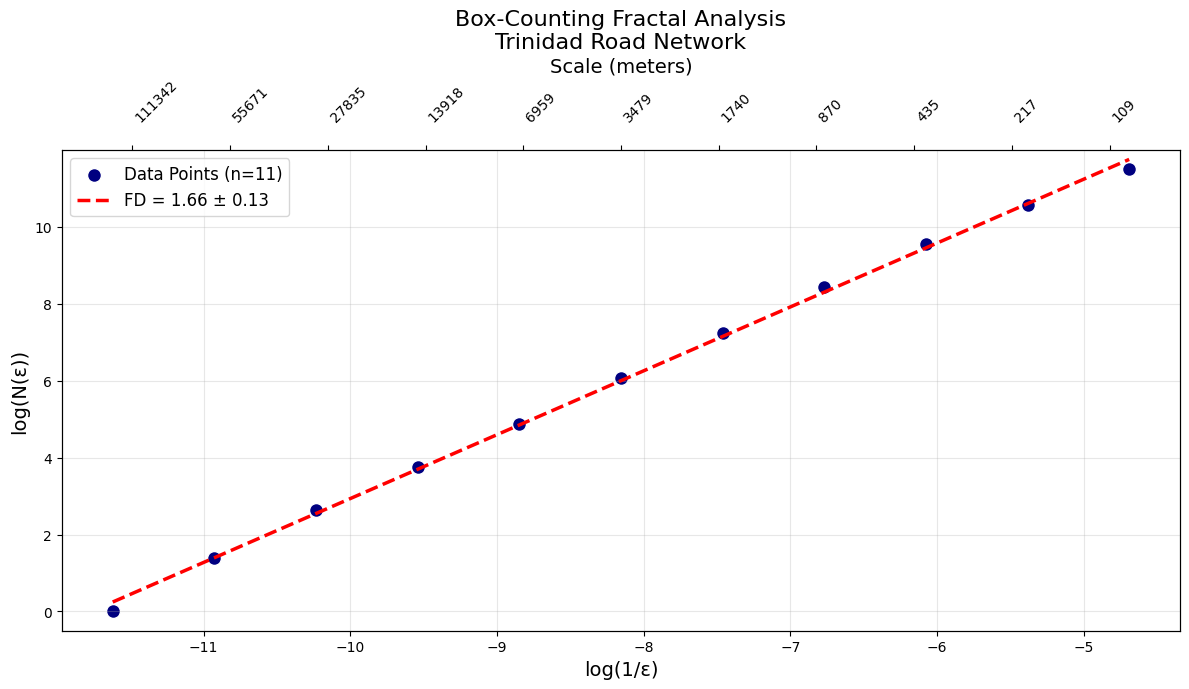

In [8]:
# Install required packages
!pip install geopandas rasterio scikit-learn matplotlib

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import os

# Upload the ZIP file containing shapefiles
uploaded = files.upload()

# Unzip the uploaded file
!unzip Trinidad_Road.zip

# Load the road data with validation
try:
    roads = gpd.read_file('Trinidad_Road.shp')
    print(f"Successfully loaded {len(roads)} road features")
except Exception as e:
    print(f"Error loading shapefile: {str(e)}")
    raise

# Project to UTM Zone 20N (EPSG:32620) if needed
if roads.crs.is_geographic:
    print("Converting to UTM CRS")
    roads = roads.to_crs(epsg=32620)

# Get the bounding box with verification
xmin, ymin, xmax, ymax = roads.total_bounds
print(f"Bounding box: {xmin:.2f}, {ymin:.2f} to {xmax:.2f}, {ymax:.2f}")

# Define epsilon range (box sizes)
max_epsilon = max(xmax - xmin, ymax - ymin)
min_epsilon = 10  # Minimum box size
print(f"Max epsilon: {max_epsilon:.2f}m, Min epsilon: {min_epsilon}m")

epsilons = []
current_epsilon = max_epsilon
while current_epsilon >= min_epsilon:
    epsilons.append(current_epsilon)
    current_epsilon /= 2

# Filter epsilons to avoid memory issues
max_pixels = 1e6
filtered_epsilons = []
for e in epsilons:
    width = (xmax - xmin) / e
    height = (ymax - ymin) / e
    if width * height > max_pixels:
        print(f"Skipping epsilon {e:.2f} m (avoids {width*height:.0f} pixels)")
        continue
    filtered_epsilons.append(e)
epsilons = filtered_epsilons

if not epsilons:
    raise ValueError("No valid epsilons - adjust min_epsilon or max_pixels")

# Box-counting implementation with progress tracking
counts = []
print("\nStarting box-counting:")
for epsilon in epsilons:
    width = int(np.ceil((xmax - xmin) / epsilon))
    height = int(np.ceil((ymax - ymin) / epsilon))

    transform = from_origin(xmin, ymax, epsilon, epsilon)

    try:
        shapes = [(geom, 1) for geom in roads.geometry]
        burned = features.rasterize(
            shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype=np.uint8,
            all_touched=True
        )
        count = np.count_nonzero(burned)
        counts.append(count)
        print(f"ε: {epsilon:.2f}m | Grid: {height}x{width} | Roads: {count}")

        # Quick sanity check
        if count == 0:
            print("Warning: Zero road pixels detected!")

    except Exception as e:
        print(f"Error at ε={epsilon:.2f}m: {str(e)}")
        continue

# Validate counts before regression
if len(counts) < 2:
    raise ValueError("Insufficient data points for regression")

# Calculate fractal dimension
x = np.log([1/e for e in epsilons]).reshape(-1, 1)
y = np.log(counts)
model = LinearRegression().fit(x, y)
fd = model.coef_[0]
r2 = model.score(x, y)

print(f"\nFractal Dimension: {fd:.3f} (R² = {r2:.3f})")

# Enhanced plotting with error handling
plt.figure(figsize=(12, 7))
plt.scatter(x, y, s=100, c='navy', edgecolor='white',
           label=f'Data Points (n={len(counts)})')
plt.plot(x, model.predict(x), 'r--', lw=2.5,
        label=f'FD = {fd:.2f} ± {np.std(y - model.predict(x)):.2f}')

plt.xlabel('log(1/ε)', fontsize=14)
plt.ylabel('log(N(ε))', fontsize=14)
plt.title('Box-Counting Fractal Analysis\nTrinidad Road Network', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Secondary axis with actual scales
ax2 = plt.gca().twiny()
ax2.set_xlabel('Scale (meters)', fontsize=14)
ax2.set_xticks(x.flatten())
ax2.set_xticklabels([f'{e:.0f}' for e in epsilons], rotation=45, ha='left')
ax2.tick_params(axis='x', which='major', pad=15)

# Ensure plot limits
plt.xlim(x.min()-0.5, x.max()+0.5)
plt.ylim(y.min()-0.5, y.max()+0.5)

plt.tight_layout()
plt.show()

# Clean up extracted files
!rm Trinidad_Road.*

Saving Trinidad_Road.zip to Trinidad_Road.zip
Archive:  Trinidad_Road.zip
  inflating: Trinidad_Road.sbn       
  inflating: Trinidad_Road.sbx       
  inflating: Trinidad_Road.cpg       
  inflating: Trinidad_Road.dbf       
  inflating: Trinidad_Road.shp       
  inflating: Trinidad_Road.shx       
  inflating: Trinidad_Road.prj       


<Figure size 1200x800 with 0 Axes>

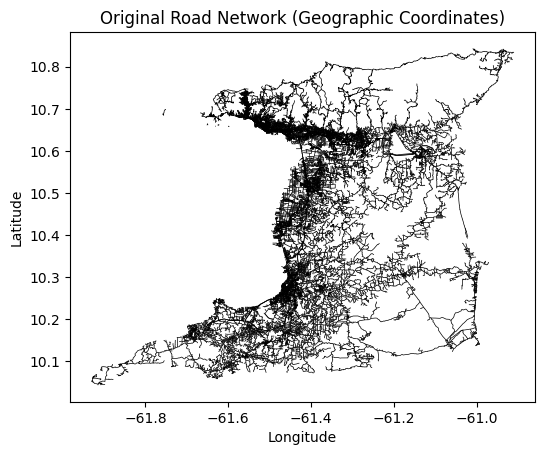

<Figure size 1200x800 with 0 Axes>

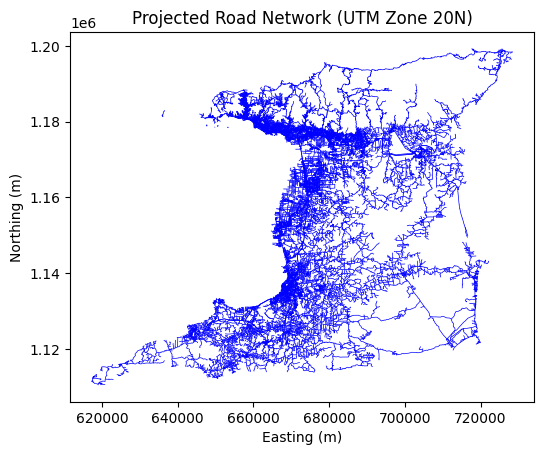

In [9]:
# Install required packages
!pip install geopandas rasterio scikit-learn matplotlib

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import os

# Upload the ZIP file containing shapefiles
uploaded = files.upload()

# Unzip the uploaded file
!unzip Trinidad_Road.zip

# Load and plot the road data
roads = gpd.read_file('Trinidad_Road.shp')

# Plot original geographic data
plt.figure(figsize=(12, 8))
roads.plot(color='black', linewidth=0.5)
plt.title('Original Road Network (Geographic Coordinates)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Project to UTM Zone 20N (EPSG:32620) if needed
if roads.crs.is_geographic:
    roads = roads.to_crs(epsg=32620)

    # Plot projected data
    plt.figure(figsize=(12, 8))
    roads.plot(color='blue', linewidth=0.5)
    plt.title('Projected Road Network (UTM Zone 20N)')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.show()

# Rest of the analysis code...
# [Keep all the existing box-counting and fractal dimension code here]